### Imports

In [1]:
import torch
import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.examples import create_3d_foam_phantom, downsample_volume, tile_volume_slices
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()
import matplotlib.pyplot as plt

### Data Loading

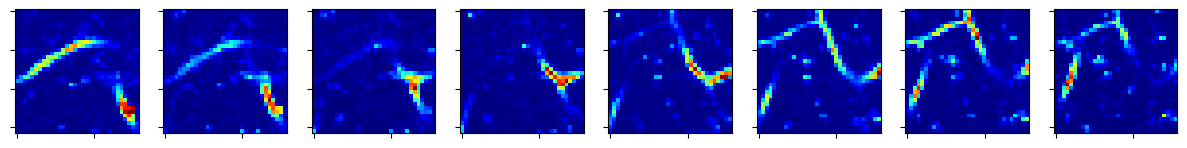

In [2]:
phi_comp=torch.load("./data/dataset/D2NN/A.pt")['matrix']
X = torch.load("./data/dataset/D2NN/Xr_blood_cell.pt")
Y = torch.load("./data/dataset/D2NN/Y_blood_cell.pt")

b = 232
n_measure = 8192

x_gt = snp.array(X[b].view(8,32,32).cpu().numpy())
phi = snp.array(phi_comp[:n_measure,:].cpu().numpy())
y = snp.array(Y[b][:n_measure].cpu().numpy())

σ = 1  # noise level
noise, key = random.randn(y.shape)
y_noisy = y + σ*noise

Afn = lambda x: phi@x.flatten()
A = linop.LinearOperator(input_shape = x_gt.shape, output_shape = y.shape, eval_fn=Afn)

fig, ax = plot.subplots(nrows=1, ncols=8, figsize=(15, 4))
for i in range(8):
    plot.imview(x_gt[i], fig=fig, ax=ax[i],cmap = "jet")
    fig.show()

### Optimization Framework

Solving on CPU

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  1.09e+00  2.747e+00  1.645e+02     10  4.149e-03
   1  2.16e+00  2.504e+00  4.372e+00     10  1.923e-03
   2  3.24e+00  2.334e+00  2.729e+00     10  1.247e-03
   3  4.47e+00  2.242e+00  3.926e+00     10  1.103e-03
   4  5.54e+00  2.202e+00  3.649e+00     10  8.423e-04
   5  6.62e+00  2.133e+00  3.094e+00     10  8.034e-04
   6  7.73e+00  2.230e+00  3.592e+00     10  6.403e-04
   7  8.82e+00  2.249e+00  3.669e+00     10  6.336e-04
   8  9.92e+00  2.376e+00  4.136e+00     10  5.176e-04
   9  1.11e+01  2.355e+00  4.134e+00     10  5.248e-04
  10  1.23e+01  2.360e+00  3.843e+00     10  4.352e-04
  11  1.35e+01  2.417e+00  4.408e+00     10  4.493e-04
  12  1.47e+01  2.460e+00  5.145e+00     10  3.772e-04
  13  1.60e+01  2.528e+00  5.833e+00     10  3.930e-04
  14  1.72e+01  2.462e+00  6.173e+00     10  3.382e-04
  15  1.85e+01  2.751e+00  6.811e+00     10  3.50

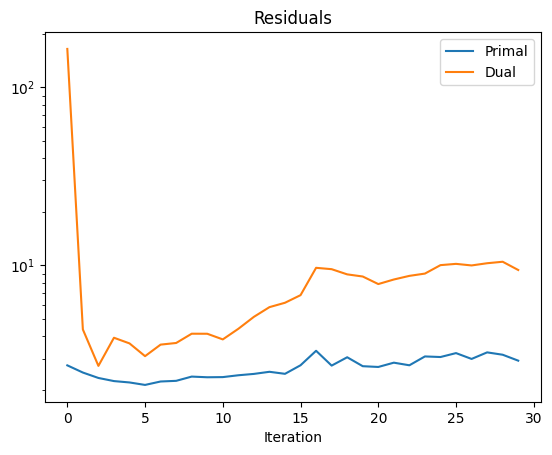

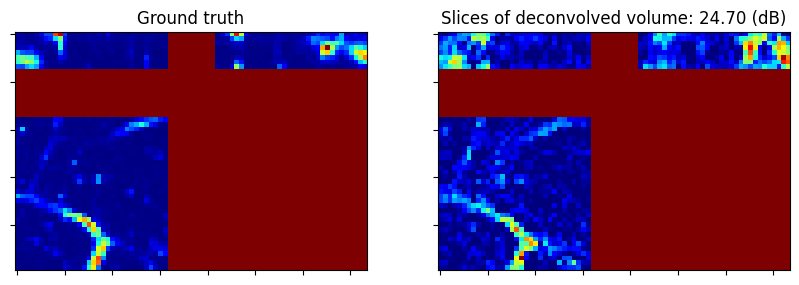

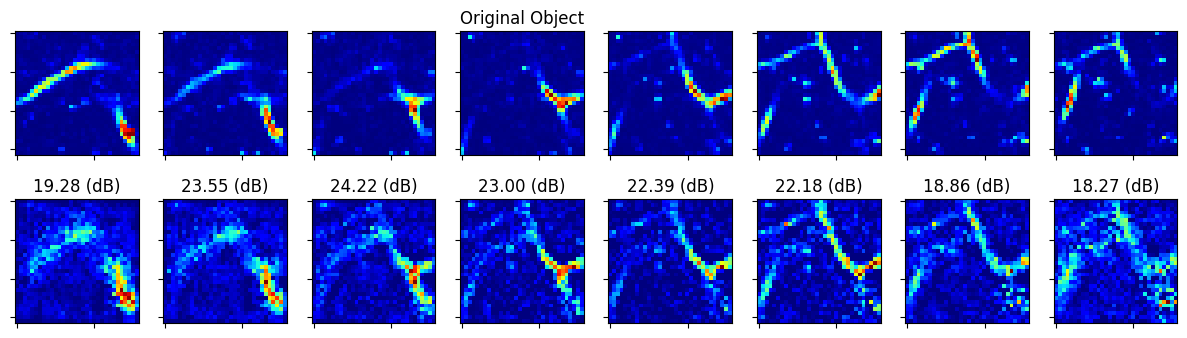

In [5]:
f = loss.SquaredL2Loss(y=y_noisy, A=A)
C = linop.Identity(x_gt.shape)

λ = .8
g = λ * functional.BM4D()


ρ = 5 
maxiter = 30 

x_init = (A.T @ y_noisy)
x_init = (x_init-x_init.min())/(x_init.max()-x_init.min())

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x_init,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-5, "maxiter": 10}),
    itstat_options={"display": True},
)

print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot.imview(tile_volume_slices(x_gt), title="Ground truth", fig=fig, ax=ax[0],cmap = 'jet')
plot.imview(tile_volume_slices(x,sep_width=10), title="Slices of deconvolved volume: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[1],cmap = 'jet' )
fig.show()

fig, ax = plot.subplots(nrows=2, ncols=8, figsize=(15, 4))
for i in range(8):
    if i==3:
        plot.imview(x_gt[i], fig=fig, ax=ax[0][i],cmap = "jet", title="Original Object")
    else:
        plot.imview(x_gt[i], fig=fig, ax=ax[0][i],cmap = "jet")
    plot.imview(x[i],fig=fig,ax=ax[1][i],cmap = "jet", title=f"{metric.psnr(x_gt[i], x[i]):.2f} (dB)")
    fig.show()

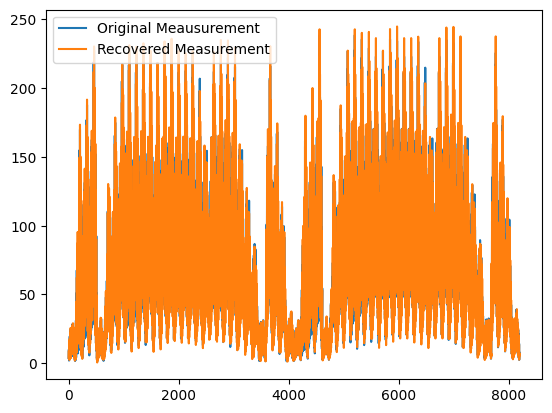

In [112]:
p = snp.vstack((snp.array(y_noisy), snp.array(Afn(x))))
plot.plot(p.reshape(-1,2), lgnd=["Original Meausurement", "Recovered Measurement"])

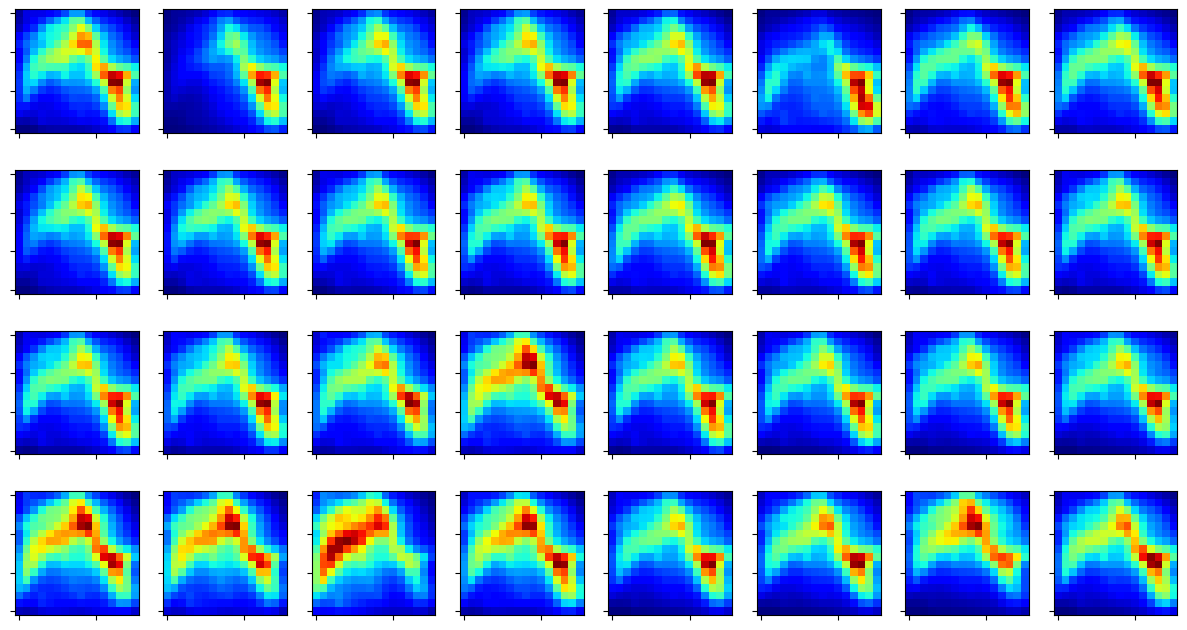

In [113]:
measure = y.reshape(-1,16,16)
fig, ax = plot.subplots(nrows=4, ncols=8, figsize=(15, 8))
for i in range(32):
    row, col= i//8, i%8
    plot.imview(measure[i], fig=fig, ax=ax[row][col],cmap = "jet")
    fig.show()